In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 20kB/s 


In [2]:
!pip install tf-nightly

     |████████████████████████████████| 324.4MB 53kB/s 
     |████████████████████████████████| 11.6MB 51.9MB/s 
     |████████████████████████████████| 460kB 52.5MB/s 


In [3]:
import os
import zipfile
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
local_zip = '/content/drive/My Drive/Project/chest_xray/CHEST_XRAY.zip'
zipref=zipfile.ZipFile(local_zip,'r')
zipref.extractall('/tmp')
zipref.close()

In [13]:
base_dir = '/tmp/CHEST_XRAY'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir,'test')

train_Normal_dir = os.path.join(train_dir,'NORMAL')
train_Pneumonia_dir = os.path.join(train_dir,'PNEUMONIA')

test_Normal_dir = os.path.join(test_dir,'NORMAL')
test_Pneumonia_dir = os.path.join(test_dir,'PNEUMONIA')

In [14]:
train_Normal_fnames = os.listdir(train_Normal_dir)
train_Pneumonia_fnames = os.listdir(train_Pneumonia_dir)


In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
import matplotlib.image as mpimg

In [16]:
train_data_gen = ImageDataGenerator(rescale=1.0/255.0,
                                rotation_range=20,
                                fill_mode='nearest',
                                vertical_flip=True,
                                horizontal_flip = True
                               )
train_data = train_data_gen.flow_from_directory(train_dir,
                                                target_size = (300,300),
                                                class_mode = 'binary'
                                                )

test_data_gen = ImageDataGenerator(rescale=1.0/255.0)
test_data = test_data_gen.flow_from_directory(test_dir,
                                             target_size = (300,300),
                                             class_mode='binary')

Found 5208 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [17]:
print('total training Normal images :', len(os.listdir(train_Normal_dir)))
print('total training Pneumonia images :', len(os.listdir(train_Pneumonia_dir)))

print('total test Normal images :', len(os.listdir(test_Normal_dir)))
print('total test Pneumonia images :', len(os.listdir(test_Pneumonia_dir)))

total training Normal images : 1341
total training Pneumonia images : 3867
total test Normal images : 234
total test Pneumonia images : 390


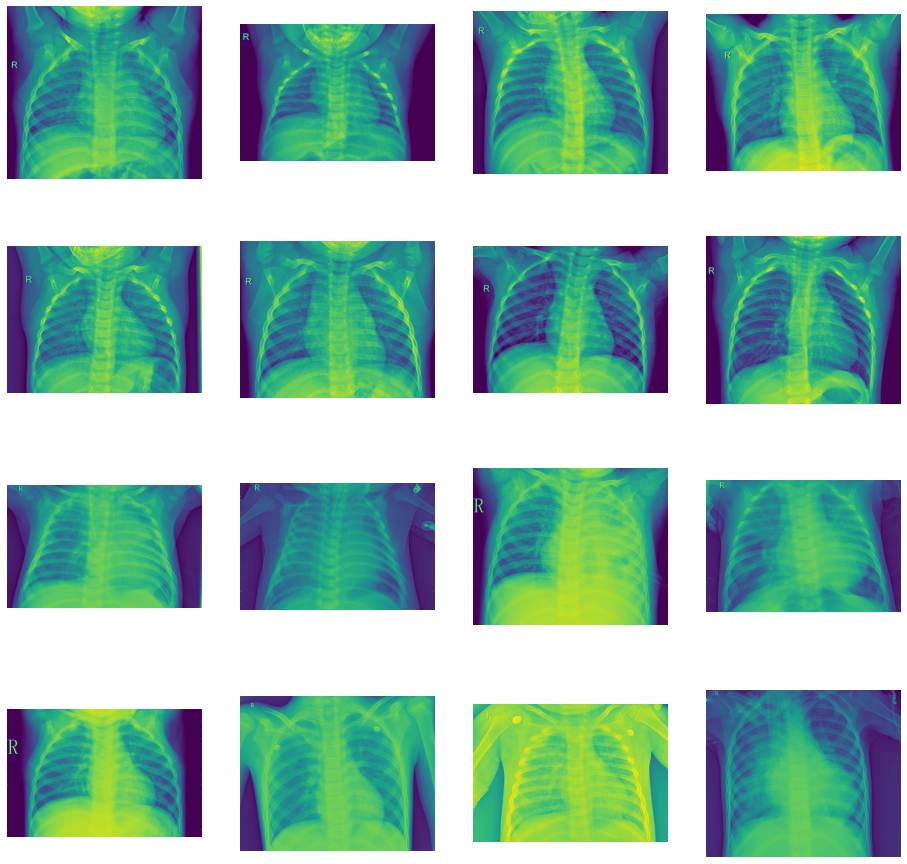

In [18]:
%matplotlib inline
def Visualize_Random_Samples():
  nrows = 4
  ncols = 4
  pic_index = 0
  fig = plt.gcf()
  fig.set_size_inches(ncols*4, nrows*4)

  pic_index+=8

  next_cat_pix = [os.path.join(train_Normal_dir, fname) 
                  for fname in train_Normal_fnames[ pic_index-8:pic_index] 
                 ]

  next_dog_pix = [os.path.join(train_Pneumonia_dir, fname) 
                  for fname in train_Pneumonia_fnames[ pic_index-8:pic_index]
                 ]

  for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

  plt.show()

Visualize_Random_Samples()

In [30]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (300, 300, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2020-08-07 16:31:01--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   116MB/s    in 0.7s    

2020-08-07 16:31:02 (116 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 17, 17, 768)


In [31]:
x = layers.Conv2D(256,(3,3),activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=tf.keras.regularizers.l2(1e-4))(last_output)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(1,(1,1),activation = 'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64,(3,3),activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.Conv2D(1,(1,1),activation = 'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x) 
x = layers.Dense(64,activation = 'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(64,activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1,activation = 'sigmoid')(x)
model = Model(pre_trained_model.input,x)
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d_294 (Conv2D)             (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_291 (BatchN (None, 149, 149, 32) 96          conv2d_294[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 149, 149, 32) 0           batch_normalization_291[0][0]    
_______________________________________________________________________________________

In [32]:
epochs_to_wait_for_improve = 20
n_epochs = 50
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=epochs_to_wait_for_improve)
checkpoint_callback = ModelCheckpoint('BINARY'+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(train_data,validation_data=test_data,
            epochs=n_epochs, callbacks=[early_stopping_callback, checkpoint_callback])

Epoch 1/50
163/163 [==============================] - ETA: 0s - loss: 0.8699 - precision_3: 0.9288 - recall_3: 0.8178 - accuracy: 0.8238
Epoch 00001: val_loss improved from inf to 0.84820, saving model to BINARY.h5
163/163 [==============================] - 162s 992ms/step - loss: 0.8695 - precision_3: 0.9290 - recall_3: 0.8182 - accuracy: 0.8243 - val_loss: 0.8482 - val_precision_3: 0.6250 - val_recall_3: 1.0000 - val_accuracy: 0.6250
Epoch 2/50
163/163 [==============================] - ETA: 0s - loss: 0.6387 - precision_3: 0.9853 - recall_3: 0.9428 - accuracy: 0.9468
Epoch 00002: val_loss improved from 0.84820 to 0.67679, saving model to BINARY.h5
163/163 [==============================] - 156s 954ms/step - loss: 0.6384 - precision_3: 0.9853 - recall_3: 0.9428 - accuracy: 0.9469 - val_loss: 0.6768 - val_precision_3: 0.7236 - val_recall_3: 1.0000 - val_accuracy: 0.7612
Epoch 3/50
163/163 [==============================] - ETA: 0s - loss: 0.4545 - precision_3: 0.9891 - recall_3: 0.959

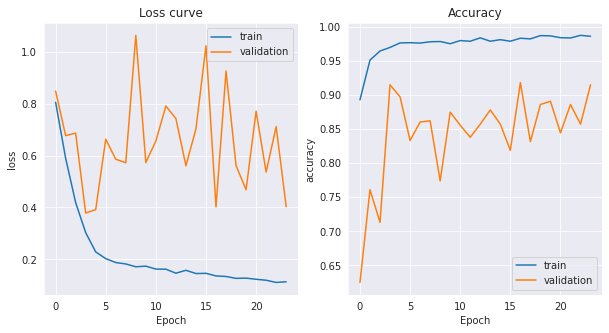

In [33]:
sns.set_style("darkgrid")
train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

#get the entries
xvalues = np.arange(len(train_acc))

#visualise
f, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(xvalues, train_loss)
ax[0].plot(xvalues, valid_loss)
ax[0].set_title("Loss curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'validation'])

ax[1].plot(xvalues,  train_acc)
ax[1].plot(xvalues, valid_acc)
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend(['train', 'validation'])

plt.show()